# Katakana Recognition
### Aimed to support Japanese handwriting Learning
The Japanese language consists of 3 writing systems, Hirgana, Katakana and Kanji. In this notebook, we will implement a Convolutional Neural Network that recognizes handwritten Katakana characters, it will be trained on images from the **ETLCDB database** (http://etlcdb.db.aist.go.jp/).

*Database used: ETL6 Character Database, Electrotechnical Laboratory, Japanese Technical Committee for Optical Character Recognition, ETL Character Database, 1973-1984.*

In [2]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## GPU Acceleration
Since deep learning involves huge amounts of matrix computations, moving the calculations onto a GPU allows for parallel computing to save time, especially for model training.

Since I am using a Mac, I will be using **Apple's MPS GPU framework** to do acceleration, if you have a **CUDA GPU**, you can use that instead.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

## ETLCDB Data
#### Reformatting the data to be PyTorch compatible

We will be using datasets.ImageFolder from the torchvision package to load our images into the notebook, however this only works for the following structure:

/Root

-- class1/

-- class2/

-- class3/

...




Since all the different characters are separated between different *unpack* directories, and are described by a particular csv file, we go through all the csv files to obtain the index range of the images of each character
E.g.

**ア ranges from index 0 to 1382, イ from 1383 to 2765 ...**

In [ ]:
import csv
import os

os.chdir('/Users/krishteee/Desktop/JapaneseOCR') #Replace with the directory your notebook is in

data_csv = [['ETL6C_01_unpack', 'ETL6C_02_unpack', 'ETL6C_03_unpack', 'ETL6C_04_unpack', 'ETL6C_05_unpack'],
            ['meta01.csv', 'meta02.csv', 'meta03.csv', 'meta04.csv', 'meta05.csv']]

csvs = data_csv[1]
all_classes = []
for csv_file in csvs:
    with open(csv_file, 'r') as csv_opened: #'r' specified that I am reading this csv file
        csv_reader = csv.reader(csv_opened)

        next(csv_reader) #returns row 0, so that when we iterate through the iterator afterwards, we skip past the row header
        initial = next(csv_reader)
        all_classes.append([initial[1], 0])

        newest_char = initial[1]
        i = 0
        for i, line in enumerate(csv_reader):
            if(newest_char != line[1]): #if true, means we have encountered a new character, create new class
                newest_char = line[1]

                all_classes[-1].append(i) #line index of last row with the same character
                all_classes.append([newest_char, i+1])
            
        all_classes[-1].append(i) #Manually append line index of last row to the last class
        print(f"Size: {len(all_classes)} --> {all_classes}\n")

if not os.path.exists('katakana') :
    os.mkdir('katakana') #This will be your target directory containing the reformatted images



Below, we first make the directories for each class within the target directory.
Then, we look into the directories holding the unpacked images.

**Conveniently, the images are named [the index].png**, so we split the image file name from its file type "png", then check if the index is within the range of the class we have iterated to, if so, we move the image to the respective class of the target directory

In [ ]:
import shutil #file operations


source_dir = '/Users/krishteee/Desktop/JapaneseOCR/ETL6' #Replace with directory holding your unpacked ETLCDB images
target_dir = '/Users/krishteee/Desktop/JapaneseOCR/katakana' #Replace with target directory you want the reformatted data to be in


os.makedirs(target_dir, exist_ok = True)
for katakana in all_classes: #Creates all class folders in destination katakana folder
    class_dir = os.path.join(target_dir, katakana[0])
    os.makedirs(class_dir, exist_ok = True)

i = 0
for pack_no, image_group in enumerate(data_csv[0]):

    image_dir = os.path.join(source_dir, image_group)
    while i < (pack_no+1)*10:
        image_move_op_count = 0
        actual_image_moved = 0

        class_dir = os.path.join(target_dir, all_classes[i][0])

        for image in os.listdir(image_dir):
            if image == '.DS_Store':
                continue #skips this iteration
            
            image_no = int(os.path.splitext(image)[0])
            if (image_no >= all_classes[i][1]) and (image_no <= all_classes[i][2]):
                image_file = os.path.join(image_dir, image)
                destination_file = os.path.join(class_dir, image)
                if os.path.isfile(image_file):
                    try:
                        shutil.move(image_file, destination_file)
                        actual_image_moved += 1
                    except Exception as e:
                        print(f"{e}    Error moving {image} under {image_dir}")

                image_move_op_count += 1
            if image_move_op_count == (all_classes[i][2]-all_classes[i][1] +1):
                print(f"Image moving for this class complete. Images moved: {actual_image_moved}")
                break

        i += 1


## With image structure reformatted, we can now move onto the actual CNN part of the project

## Load the Data

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_split = 0.1

test_split = 0.1

In [ ]:
train_dir = '/Users/krishteee/Desktop/JapaneseOCR/katakana' #Replace with your own directory containing all the images

train_transform = transforms.Compose([  transforms.RandomRotation(15),
                                        transforms.Resize(36),
                                        transforms.CenterCrop(32),
                                        transforms.Grayscale(num_output_channels=1), #convert to grayscale to reduce redundant computation
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5))])

test_transform = transforms.Compose([   transforms.Resize(36),
                                        transforms.CenterCrop(32),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5))])

train_set = datasets.ImageFolder(train_dir, transform = train_transform)
test_set = datasets.ImageFolder(train_dir, transform = test_transform) #Same dataset, but different transforms since we don't need augmentation for testing
#Concern: Whether the order of the dataset is different everytime you load dataset

train_size = len(train_set)

indices = list(range(train_size))
np.random.shuffle(indices)

valid_size = int(np.floor(valid_split * train_size))
test_size = int(np.floor(test_split * train_size))

train_indices = indices[(valid_size + test_size): ]
valid_indices = indices[: valid_size]
test_indices = indices[valid_size: (valid_size + test_size)]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)


train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, sampler = test_sampler)

In [ ]:
print(train_set.class_to_idx) #Dictionary mapping class name to index
#Lexicographical order, which caused the initial problem

{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '6': 46, '7': 47, '8': 48, '9': 49}


In [6]:
# specify the image classes
classes = ['ア', 'イ', 'ウ', 'エ','オ','カ', 'キ', 'ク', 'ケ', 'コ', 'サ', 'シ', 'ス', 'セ', 'ソ', 'タ', 'チ', 'ツ', 'テ', 'ト', 'ナ', 'ニ', 'ヌ', 'ネ', 'ノ', 'ハ', 'ヒ', 'フ', 'ヘ', 'ホ', 'マ', 'ミ', 'ム', 'メ', 'モ', 'ヤ', 'ユ', 'ヨ', 'ラ', 'リ', 'ル', 'レ', 'ロ', 'ワ', 'ヲ', 'ン', 'ﾞ', 'ﾟ', '「', '」']

### Visualize a Batch of Training Data

In [7]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
# obtain one batch of training images

images, labels = next(iter(train_loader))
images = images.numpy() # convert images to numpy for display
images.shape

<class 'torch.Tensor'>


(20, 1, 32, 32)

In [8]:
#configure matplotlib to a japanese-supported font
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

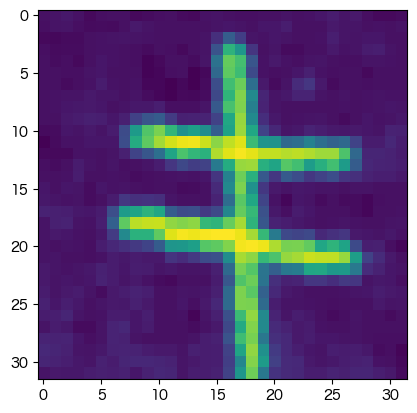

tensor([ 6, 45, 47, 25, 19, 24, 18,  8,  0, 16, 16, 42, 24, 47,  0, 29, 16, 32,
        38,  6])


In [17]:
imshow(images[0])

plt.show()

print(labels)

In [116]:
#Seems like the indices are mismatched, may have been better to just name the folders 0,1,2,3..., then correspond them to the classes list

for katakana in all_classes: #Creates all class folders in destination katakana folder
    class_dir = os.path.join(target_dir, katakana[0])
    os.rename(class_dir, str(all_classes.index(katakana)))

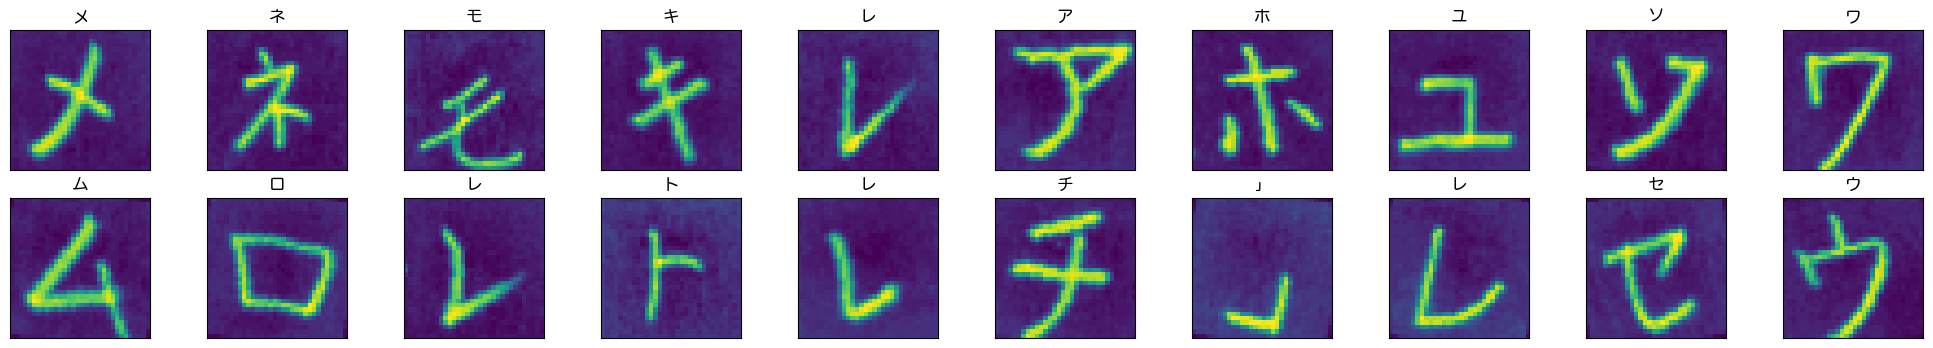

In [271]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

### Defining the CNN architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 50) #Switched from hiragana to katakana, so 46 --> 50!
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [10]:
# create a complete CNN
model = Net()
model

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [11]:
model.to(device)
device

device(type='mps')

### Specify Loss Function

In [12]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.1)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [ ]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'katakanaCNN2.pt') #PyTorch automatically creates this file in your directory
        #if it doesn't already exist
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.673516 	Validation Loss: 0.086151
Validation loss decreased (inf --> 0.086151).  Saving model ...
Epoch: 2 	Training Loss: 0.094000 	Validation Loss: 0.048747
Validation loss decreased (0.086151 --> 0.048747).  Saving model ...
Epoch: 3 	Training Loss: 0.063636 	Validation Loss: 0.044432
Validation loss decreased (0.048747 --> 0.044432).  Saving model ...
Epoch: 4 	Training Loss: 0.045914 	Validation Loss: 0.041038
Validation loss decreased (0.044432 --> 0.041038).  Saving model ...
Epoch: 5 	Training Loss: 0.037178 	Validation Loss: 0.044504
Epoch: 6 	Training Loss: 0.031911 	Validation Loss: 0.048128
Epoch: 7 	Training Loss: 0.030247 	Validation Loss: 0.039764
Validation loss decreased (0.041038 --> 0.039764).  Saving model ...
Epoch: 8 	Training Loss: 0.025847 	Validation Loss: 0.034894
Validation loss decreased (0.039764 --> 0.034894).  Saving model ...
Epoch: 9 	Training Loss: 0.023266 	Validation Loss: 0.026164
Validation loss decreased (0.034894 --> 0.

###  Load the Model with the Lowest Validation Loss

In [13]:
model.load_state_dict(torch.load('katakanaCNN2.pt'))

<All keys matched successfully>

## Test the Trained Network

Test the trained model on previously unseen data

In [24]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(50))
class_total = list(0. for i in range(50))

model.eval()
# iterate over test data
for data, target in test_loader:

    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.backends.mps.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except IndexError:
            continue #To avoid IndexError when last batch has less than batch_size images, we could do break, but continue would be more robust

# average test loss
test_loss = test_loss/len(train_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(46):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000511

Test Accuracy of     ア: 99% (149/150)
Test Accuracy of     イ: 100% (130/130)
Test Accuracy of     ウ: 100% (124/124)
Test Accuracy of     エ: 100% (128/128)
Test Accuracy of     オ: 100% (139/139)
Test Accuracy of     カ: 100% (143/143)
Test Accuracy of     キ: 100% (132/132)
Test Accuracy of     ク: 99% (122/123)
Test Accuracy of     ケ: 100% (125/125)
Test Accuracy of     コ: 100% (128/128)
Test Accuracy of     サ: 100% (130/130)
Test Accuracy of     シ: 100% (141/141)
Test Accuracy of     ス: 100% (127/127)
Test Accuracy of     セ: 100% (131/131)
Test Accuracy of     ソ: 100% (146/146)
Test Accuracy of     タ: 100% (145/145)
Test Accuracy of     チ: 99% (144/145)
Test Accuracy of     ツ: 100% (139/139)
Test Accuracy of     テ: 100% (142/142)
Test Accuracy of     ト: 100% (144/144)
Test Accuracy of     ナ: 100% (152/152)
Test Accuracy of     ニ: 100% (138/138)
Test Accuracy of     ヌ: 100% (139/139)
Test Accuracy of     ネ: 100% (138/138)
Test Accuracy of     ノ: 100% (131/131)
Test Ac

### Now on my own testset

If interested to see how well the CNN works in detecting your handwriting, you can take a couple of screenshots of your own handwriting and have them in a folder. You do not have to separate them into the corresponding classes, you can display the image with plt.show(), look at the result and check for yourself.

Interesting point to note:

**The sample data has white characters on a dark background, so if your colours are inverted, i.e. black characters on white, you will find that it is much less accurate! We will invert the colours in our transforms below**

**In fact, even the stroke thickness could affect the result, since the model has only seen that specific handwriting format of the training data and nothing else**

For a general purpose OCR, this counts as overfitting; however, for the purpose of a handwriting practice web app, I intend to restrict the stroke thickness and formatting to match that of the training data, hence it is not a problem.

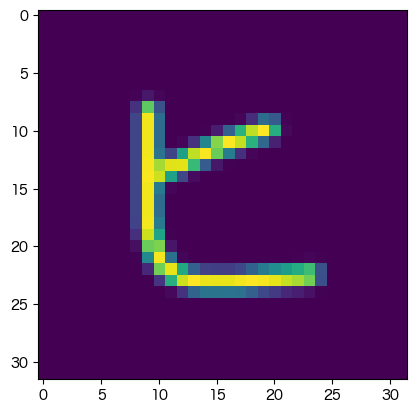

torch.Size([1, 1, 32, 32])


In [ ]:
test_dir = '/Users/krishteee/Desktop/JapaneseOCR/EmergentWebAppDemo' #Replace with the directory containing your own handwritings

my_test_transform = transforms.Compose([transforms.Resize(36),
                                        transforms.CenterCrop(32),
                                        transforms.Grayscale(num_output_channels = 1),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5),(0.5)),
                                        transforms.Lambda(lambda x: transforms.functional.invert(x))]) #Inverting colors because my test set has black characters on white bg

my_test_set = datasets.ImageFolder(test_dir, transform = my_test_transform)
my_test_loader = torch.utils.data.DataLoader(my_test_set, batch_size = 1, shuffle = True)

image, label = next(iter(my_test_loader))
imshow(image[0])
plt.show()
print(image.shape)

torch.Size([1, 1, 32, 32])
Images[0] --> キ, Second likely --> モ


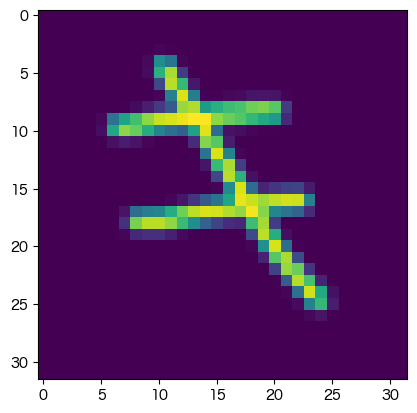

In [ ]:
images, labels = next(iter(my_test_loader))


model.to(device)
images, labels = images.to(device), labels.to(device)
model.eval()

output = model(images)
top_k_val, top_k_idx = output.topk(2, dim = 1)


for i in range(images.shape[0]):
    imshow(images[i].cpu())
    print(f"Images[{i}]: Most likely --> {classes[top_k_idx[i][0].item()]}, Second likely --> {classes[top_k_idx[i][1].item()]}")
    plt.show()
